In [26]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

In [27]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
csv_data = pd.read_csv('/content/drive/MyDrive/data/pmi-data.csv')

print(csv_data.describe())
# print(csv_data.head())

                 id       gender          age  hypertension  heart_disease  \
count   3566.000000  3566.000000  3566.000000   3566.000000    3566.000000   
mean   36785.750701     1.394279    48.853898      0.125070       0.063937   
std    21239.999608     0.489337    18.874375      0.330845       0.244675   
min       67.000000     0.000000    10.000000      0.000000       0.000000   
25%    18042.750000     1.000000    34.000000      0.000000       0.000000   
50%    37448.500000     1.000000    50.000000      0.000000       0.000000   
75%    54984.250000     2.000000    63.000000      0.000000       0.000000   
max    72915.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  Residence_type  avg_glucose_level  \
count   3566.000000  3566.000000     3566.000000        3566.000000   
mean       0.759955     3.424846        0.491307         108.982011   
std        0.427170     0.894640        0.499995          48.292204   
min        0.

In [29]:
X_train = csv_data[csv_data['split'] == 'train'].drop(columns=['split', 'stroke'])
y_train = csv_data[csv_data['split'] == 'train']['stroke']
X_test = csv_data[csv_data['split'] == 'test'].drop(columns=['split', 'stroke'])
y_test = csv_data[csv_data['split'] == 'test']['stroke']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=17)

print(X_train.describe())
print(y_train.describe())
print(X_test.describe())
print(y_test.describe())
print(X_val.describe())
print(y_val.describe())

# X_train.head()
# y_train.head()
# X_test.head()
# y_test.head()
# X_val.head()
# y_val.head()

train_positives = y_train.sum()
train_negatives = y_train.shape[0] - train_positives
train_ratio = train_negatives / train_positives

print(f'Train Dataset Imbalance: {train_positives}, {train_negatives}, Ratio: {train_ratio}')

                 id       gender          age  hypertension  heart_disease  \
count   2139.000000  2139.000000  2139.000000   2139.000000    2139.000000   
mean   36897.204769     1.391772    48.820009      0.131837       0.067789   
std    21212.797319     0.489217    18.932919      0.338393       0.251442   
min       67.000000     0.000000    10.000000      0.000000       0.000000   
25%    18248.500000     1.000000    34.000000      0.000000       0.000000   
50%    37349.000000     1.000000    50.000000      0.000000       0.000000   
75%    55556.000000     2.000000    63.000000      0.000000       0.000000   
max    72882.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  Residence_type  avg_glucose_level  \
count   2139.000000  2139.000000     2139.000000        2139.000000   
mean       0.767181     3.437120        0.487611         108.984175   
std        0.422727     0.885992        0.499963          48.771008   
min        0.

Why splitting the dataset into a train and validation set is good practice:
- it prevents overfitting, if we train and evaluate models on same data they might simply memorize the outputs
- by providing the model with data it has never seen during the training phase, we can ensure that it is able to generalize
- the validation data should be large enough to give a clear evaluation of the model's ability to generalize, but not too much, as that would leave insufficient data for training


In [30]:
class StrokeDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return self.length

train_dataset = StrokeDataset(X_train, y_train)
test_dataset = StrokeDataset(X_test, y_test)
val_dataset = StrokeDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [31]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(NeuralNetwork, self).__init__()

    if (hidden_sizes is None) or len(hidden_sizes) == 0:
      raise ValueError('hidden_sizes is None or empty')

    layers = []
    layers.append(nn.Linear(input_size, hidden_sizes[0]))
    for idx in range(1, len(hidden_sizes)):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(hidden_sizes[idx - 1], hidden_sizes[idx]))

    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    # layers.append(nn.Sigmoid())

    self.layers = nn.ModuleList(layers)

  def forward(self, X):
    for layer in self.layers:
      X = layer(X)
    return X

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[16, 16, 16], output_size=1)
model.to(device)

for param in model.parameters():
  print(param.shape)

torch.Size([16, 11])
torch.Size([16])
torch.Size([16, 16])
torch.Size([16])
torch.Size([16, 16])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])


In [41]:
optimizer = optim.Adam(model.parameters())
loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([train_ratio]).to(device))

epochs = 128

train_epoch_losses = []
train_accuracies = []

val_epoch_losses = []
val_accuracies = []

val_predictions = []
val_labels = []

for epoch in range(epochs):
  model.train()

  epoch_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = loss_function(outputs.view(-1), y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    predictions = (torch.sigmoid(outputs) > 0.5).float()
    correct_predictions += (predictions == y_batch).sum().item()
    total_predictions += y_batch.size(0)

  accuracy = correct_predictions / total_predictions
  avg_epoch_loss = epoch_loss / len(train_loader)

  train_epoch_losses.append(avg_epoch_loss)
  train_accuracies.append(accuracy)

  print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}, Accuracy: {accuracy}')

  model.eval()

  epoch_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  val_predictions = []
  val_labels = []

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(X_batch)
      loss = loss_function(outputs.view(-1), y_batch)

      epoch_loss += loss.item()

      predictions = (torch.sigmoid(outputs) > 0.5).float()
      correct_predictions += (predictions == y_batch).sum().item()
      total_predictions += y_batch.size(0)

      val_predictions.extend(predictions.cpu().numpy())
      val_labels.extend(y_batch.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    avg_epoch_loss = epoch_loss / len(val_loader)

    val_epoch_losses.append(avg_epoch_loss)
    val_accuracies.append(accuracy)

    print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}, Accuracy: {accuracy}')

Training, Epoch 1/128, Loss: 1.3545770476113503, Accuracy: 17.806451612903224
Validation, Epoch 1/128, Loss: 2.03180767401405, Accuracy: 2.230014025245442
Training, Epoch 2/128, Loss: 1.2839932041381723, Accuracy: 17.67461430575035
Validation, Epoch 2/128, Loss: 1.8986016097276106, Accuracy: 29.41374474053296
Training, Epoch 3/128, Loss: 1.2807698712420108, Accuracy: 29.29172510518934
Validation, Epoch 3/128, Loss: 1.9765573843665745, Accuracy: 29.539971949509116
Training, Epoch 4/128, Loss: 1.2814360207586146, Accuracy: 17.299672744273025
Validation, Epoch 4/128, Loss: 1.9686498667882837, Accuracy: 29.50631136044881
Training, Epoch 5/128, Loss: 1.2796362184766512, Accuracy: 29.387564282374942
Validation, Epoch 5/128, Loss: 1.9995749566866003, Accuracy: 29.50631136044881
Training, Epoch 6/128, Loss: 1.2782254708347036, Accuracy: 29.398316970546986
Validation, Epoch 6/128, Loss: 2.133584740369216, Accuracy: 29.50631136044881
Training, Epoch 7/128, Loss: 1.2745098293717227, Accuracy: 29.

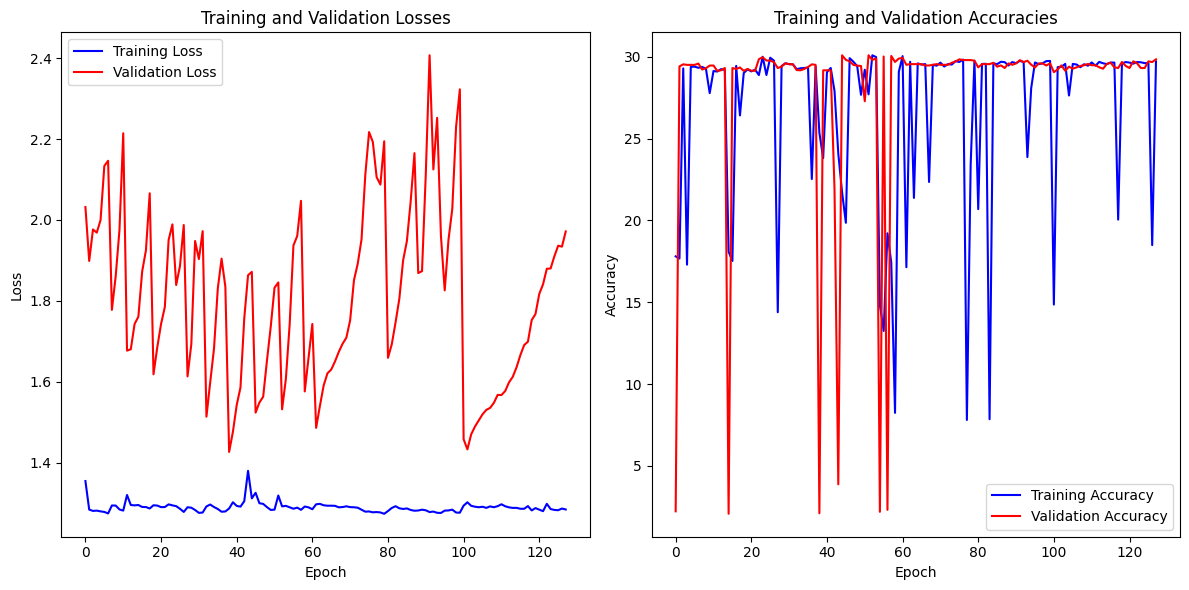

In [42]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_epoch_losses, label='Training Loss', color='blue')
plt.plot(val_epoch_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

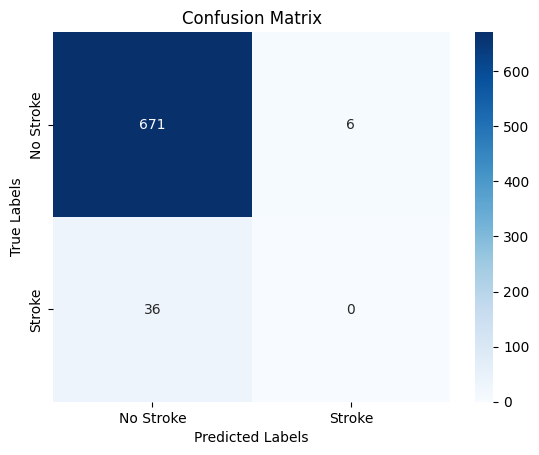

Precision: [0.94908062 0.        ]
Recall: [0.99113737 0.        ]
F1 Score: [0.96965318 0.        ]


In [43]:
val_predictions = np.array(val_predictions).reshape(-1)
val_labels = np.array(val_labels).reshape(-1)

conf_matrix = confusion_matrix(val_labels, val_predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(val_labels, val_predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')